<a href="https://colab.research.google.com/github/HuinaGabriela/Fast_CNN_Classifier_with_VGG16/blob/main/Conhe%C3%A7a_o_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Classificador de Imagens: Gatos vs Cachorros (com VGG16 e Fine-Tuning)

In [32]:
# Bibliotecas principais
import os
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img


In [23]:
# Upload e Extração do Dataset

from google.colab import files

# Upload do arquivo zip
uploaded = files.upload()

# Nome do arquivo zip enviado
zip_file = 'classificador_de_imagens.zip'

# Remove a pasta anterior, se existir
if os.path.exists('meu_projeto'):
    shutil.rmtree('meu_projeto')

# Extrai para a pasta desejada
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('meu_projeto')

# Verificação de conteúdo
print('Conteúdo extraído para "meu_projeto"')


Saving classificador_de_imagens.zip to classificador_de_imagens (1).zip
Conteúdo extraído para "meu_projeto"


In [24]:
# Verificação do Dataset

# Exibe algumas imagens de treino
cat_dir = '/content/meu_projeto/classificador_de_imagens/dataset/train/cats'
dog_dir = '/content/meu_projeto/classificador_de_imagens/dataset/train/dogs'

cat_images = os.listdir(cat_dir)
dog_images = os.listdir(dog_dir)

print(f'Gatos (train): {len(cat_images)} imagens')
print(f'Cachorros (train): {len(dog_images)} imagens')
print('Exemplo de arquivos:', cat_images[:3], dog_images[:3])

Gatos (train): 80 imagens
Cachorros (train): 80 imagens
Exemplo de arquivos: ['cat.4067.jpg', 'cat.4027.jpg', 'cat.4089.jpg'] ['dog.4032.jpg', 'dog.4031.jpg', 'dog.4071.jpg']


In [25]:
# Preparação dos Dados

# Diretórios
base_dir = '/content/meu_projeto/classificador_de_imagens/dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

# Parâmetros
img_size = (224, 224)
batch_size = 16
num_classes = 2

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Geradores
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)


Found 160 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [26]:
# Construção e Treinamento do Modelo (VGG16)

# Carrega a base VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelada

# Modelo sequencial
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compila e treina o classificador (base congelada)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

print("### Treinando apenas o classificador ###")
history = model.fit(train_generator, epochs=10, validation_data=val_generator)


### Treinando apenas o classificador ###
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 103s 10s/step - accuracy: 0.5478 - loss: 0.9280 - val_accuracy: 0.6000 - val_loss: 0.6724
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 96s 10s/step - accuracy: 0.5315 - loss: 0.7505 - val_accuracy: 0.6500 - val_loss: 0.6222
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 95s 10s/step - accuracy: 0.7278 - loss: 0.5733 - val_accuracy: 0.8000 - val_loss: 0.4877
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 95s 10s/step - accuracy: 0.7221 - loss: 0.4930 - val_accuracy: 0.7500 - val_loss: 0.4609
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 107s 11s/step - accuracy: 0.8384 - loss: 0.3321 - val_accuracy: 0.8000 - val_loss: 0.4703
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 107s 11s/step - accuracy: 0.8443 - loss: 0.3525 - val_accuracy: 0.8000 - val_loss: 0.4313
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 97s 10s/step - accuracy: 0.9236 - loss: 0.2519 - val_accuracy: 0.8000 - val_loss: 0.4491
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.9

In [27]:
# Fine-Tuning

# Fine-tuning das últimas camadas
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

print("### Fine-tuning das últimas camadas da VGG16 ###")
history_fine = model.fit(train_generator, epochs=10, validation_data=val_generator)


### Fine-tuning das últimas camadas da VGG16 ###
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 128s 13s/step - accuracy: 0.9371 - loss: 0.2068 - val_accuracy: 0.8000 - val_loss: 0.4317
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 114s 12s/step - accuracy: 0.9363 - loss: 0.1607 - val_accuracy: 0.8000 - val_loss: 0.4655
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 116s 12s/step - accuracy: 0.9553 - loss: 0.1299 - val_accuracy: 0.8000 - val_loss: 0.4786
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 114s 12s/step - accuracy: 0.9563 - loss: 0.1214 - val_accuracy: 0.8000 - val_loss: 0.5535
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 115s 12s/step - accuracy: 0.9344 - loss: 0.1741 - val_accuracy: 0.8000 - val_loss: 0.5110
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 115s 12s/step - accuracy: 0.9264 - loss: 0.1548 - val_accuracy: 0.8500 - val_loss: 0.4359
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 124s 13s/step - accuracy: 0.9427 - loss: 0.1207 - val_accuracy: 0.8000 - val_loss: 0.6137
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 117s 12s/step - a

In [28]:
# Salvamento do Modelo

model.save('vgg16_transfer_finetuned.keras')
print("Modelo salvo com sucesso.")


Modelo salvo com sucesso.


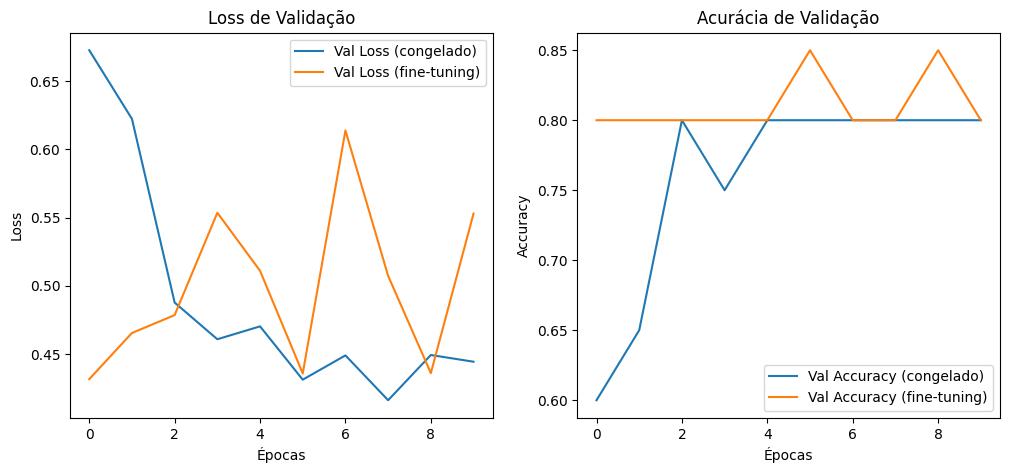

In [29]:
# Visualização dos Resultados

def plot_training(h1, h2):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(h1.history['val_loss'], label='Val Loss (congelado)')
    plt.plot(h2.history['val_loss'], label='Val Loss (fine-tuning)')
    plt.title('Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(h1.history['val_accuracy'], label='Val Accuracy (congelado)')
    plt.plot(h2.history['val_accuracy'], label='Val Accuracy (fine-tuning)')
    plt.title('Acurácia de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training(history, history_fine)


In [30]:
# Avaliação no Teste

loss, acc = model.evaluate(test_generator)
print(f'Test Loss: {loss:.4f} - Test Accuracy: {acc:.4f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8917 - loss: 0.3982
Test Loss: 0.3677 - Test Accuracy: 0.9000


In [31]:
# Predição de Novas Imagens

# Mapeamento de classes
class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

def prepare_image(img_path):
    img = load_img(img_path, target_size=img_size)
    x = img_to_array(img) / 255.0
    return np.expand_dims(x, axis=0)

def predict_image(img_path):
    x = prepare_image(img_path)
    preds = model.predict(x)
    class_idx = np.argmax(preds)
    class_name = inv_class_indices[class_idx]
    confidence = preds[0][class_idx]
    print(f'{img_path} → {class_name} ({confidence*100:.2f}%)')



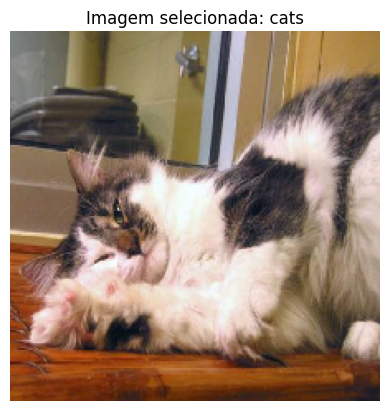

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
/content/meu_projeto/classificador_de_imagens/dataset/test/cats/cat.4059.jpg → cats (95.49%)


In [40]:
# validar se o modelo esta funcionando corretamente com conjunto de teste (/test)
# Seleciona aleatoriamente 'cats' ou 'dogs'
class_folder = random.choice(['cats', 'dogs'])

# Caminho da imagem aleatória dentro da pasta de teste
img_name = random.choice(os.listdir(os.path.join(test_dir, class_folder)))
img_path = os.path.join(test_dir, class_folder, img_name)

# Exibe a imagem escolhida
plt.imshow(load_img(img_path, target_size=img_size))
plt.title(f"Imagem selecionada: {class_folder}")
plt.axis('off')
plt.show()

# Predição
predict_image(img_path)
